### Importing Data and Necessary Packages

In [40]:
#For EDA
import pandas as pd
import numpy as np
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows', 200)
import pandas_profiling

#For Data Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.offline as po
import plotly.graph_objs as go
%matplotlib inline

#Data Pre-Processing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.under_sampling import TomekLinks
from sklearn.utils import resample

#For Modeling 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

#For Model Evaluation 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score




In [41]:
#Importing Data
df = pd.read_csv('Terry_Stops.csv')

## Data Cleaning 

In [42]:
#Combining 'SouthWest' to 'Southwest' and turning '-' into 'Not Specified' 
df['Precinct'] = df['Precinct'].replace(['SouthWest','-'], ['Southwest','Not Specified']) 
df = df[df.Precinct != 'OOJ']
df = df[df.Precinct != 'FK ERROR']
df = df[df.Precinct != 'Unknown']

#Changed 'Unknown' to 'Not Specified'
df['Officer Race'] = df['Officer Race'].replace('Unknown', 'Not Specified')

#Changed '-' and 'Unknown' into 'Not Specified'
df['Subject Perceived Race'] = df['Subject Perceived Race'].replace(['-', 'Unknown'],['Not Specified', 'Not Specified'])

#Changed '-' to 'Unknown' and 'Unable to Determine' into 'gender diverse...'
df['Subject Perceived Gender'] = df['Subject Perceived Gender'].replace('-', 'Unknown')
df['Subject Perceived Gender'] = df['Subject Perceived Gender'].replace('Unable to Determine', 'Gender Diverse (gender non-conforming and/or transgender)')


#Replaced '-' to 'NOT SPECIFIED'
df['Call Type'] = df['Call Type'].replace('-','NOT SPECIFIED')
df['Year_of_Report'] = pd.to_datetime(df['Reported Date']).dt.year
df['Year_of_Report'] = df['Year_of_Report'].astype(int)

## Feature Engineering 

In [43]:
#Creating the feature Arrested
df['Arrested'] = df['Stop Resolution'] == 'Arrest'
df['Arrested'] = df['Arrested'].replace([True, False], [1,0])

#Creating the feature White_Officer
df['White_Officer'] = (df['Officer Race'] == 'White')
df['White_Officer'] = df['White_Officer'].replace([True, False], [1,0])

#Creating the features Subject_POC
df['Subject_POC'] = df['Subject Perceived Race'] != 'White'
df['Subject_POC'] = df['Subject_POC'].replace([True, False], [1,0])

#Creating Hour, Morning, Afternoon, Evening and Night Features
df['Hour'] = pd.to_datetime(df['Reported Time'], format='%H:%M:%S').dt.hour
df['Hour'] = df['Hour'].replace(0,24)
df['Morning'] = (df['Hour'] >= 5) & (df['Hour'] < 12)
df['Morning'] = df['Morning'].replace([True,False], [1,0])
df['Afternoon']= (df['Hour'] >= 12) & (df['Hour'] < 17)
df['Afternoon'] = df['Afternoon'].replace([True,False], [1,0])
df['Evening'] = (df['Hour'] >= 17) & (df['Hour'] < 21)
df['Evening'] = df['Evening'].replace([True,False], [1,0])
df['Night'] = (df['Hour'] >= 21) & (df['Hour'] <= 24)
df['Night'] = df['Night'].replace([True,False], [1,0])

#Creating under_17 feature
df['under_17'] = df['Subject Age Group']=='1 - 17'
df['under_17'] = df['under_17'].replace([True, False], [1,0])


#Creating Officer Age Feature
df['Officer_Age'] = df['Year_of_Report'] - df['Officer YOB']
under_70 = df[df['Officer_Age']<= 70]
df['Officer YOB'] = df['Officer YOB'].astype(int)
mean_age = round(under_70['Officer_Age'].mean(), 0)
df['Officer_Age'] = df['Officer_Age'].replace([120,119,121,118,116,117,115],[mean_age,mean_age,mean_age,mean_age,mean_age,mean_age,mean_age])

dummy_df = pd.get_dummies(df, columns=['Subject Perceived Race','Stop Resolution',
                                       'Officer Race'],drop_first=True)

## Data Visualizations 

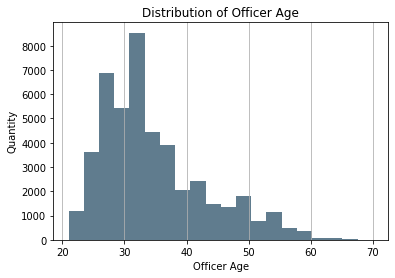

In [44]:
#Shows the distribution of Officer Age 
size, scale = 100, 10

df['Officer_Age'].plot.hist(grid=True, bins=20, rwidth=1,
                   color='#607c8e')
plt.title('Distribution of Officer Age')
plt.xlabel('Officer Age')
plt.ylabel('Quantity')
plt.grid(axis='y', alpha=0.75)

Text(0.5, 1.0, 'Stop Resolutions')

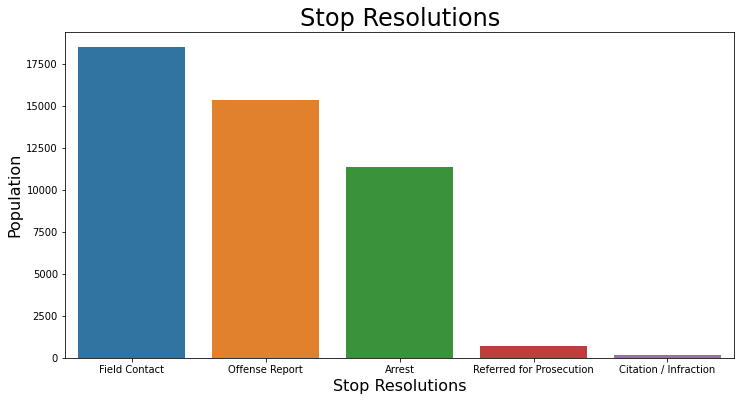

In [45]:
fig, ax = plt.subplots(figsize=(12,6))
x = df['Stop Resolution'].value_counts().index
y = df['Stop Resolution'].value_counts()

sns.barplot(x=x, y=y, ax=ax, data=df)
plt.xlabel("Stop Resolutions", size=16)
plt.ylabel("Population", size=16)
plt.title("Stop Resolutions", size=24)

[[Text(0, 0, 'Not Arrested'), Text(1, 0, 'Arrested')]]

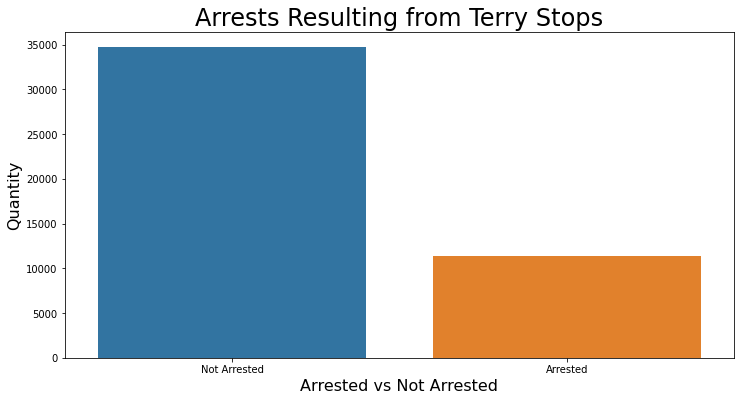

In [46]:
figure, axis = plt.subplots(figsize=(12,6))

sns.barplot(x=df['Arrested'].value_counts().index, y=df['Arrested'].value_counts())
plt.xlabel("Arrested vs Not Arrested", size=16)
plt.ylabel("Quantity", size=16)
plt.title('Arrests Resulting from Terry Stops', size=24)
axis.set(xticklabels=['Not Arrested','Arrested'])

Text(0.5, 1.0, 'Arrests Resulting from Terry Stops by Race')

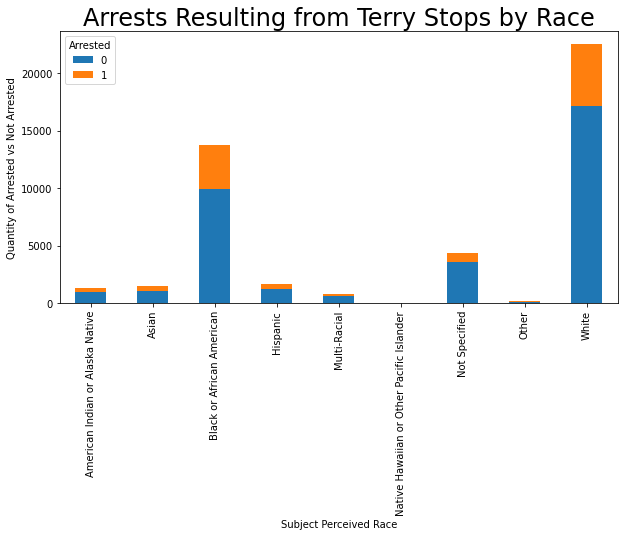

In [47]:
df.groupby(["Subject Perceived Race", "Arrested"]).size().unstack().plot(kind='bar', stacked=True, figsize=(10,5))
plt.xlabel("Subject Perceived Race", size=10)
plt.ylabel("Quantity of Arrested vs Not Arrested", size=10)
plt.title('Arrests Resulting from Terry Stops by Race', size=24)

Text(0.5, 1.0, 'Stop Resolutions by Race')

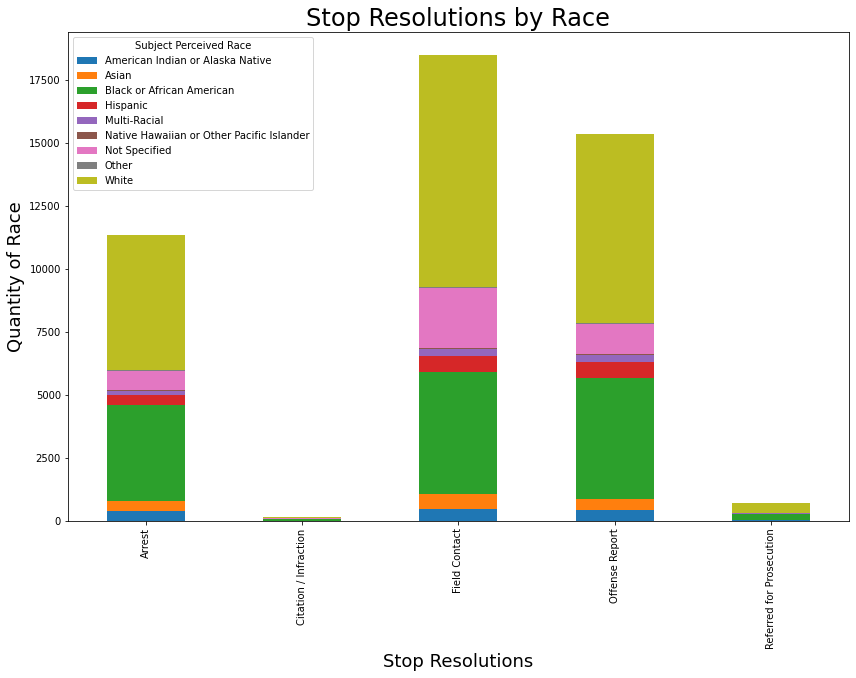

In [48]:
df.groupby(["Stop Resolution", "Subject Perceived Race"]).size().unstack().plot(kind='bar', stacked=True, figsize=(14,9))
plt.xlabel("Stop Resolutions", size=18)
plt.ylabel("Quantity of Race", size=18)
plt.title('Stop Resolutions by Race', size=24)

In [51]:
#X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)

----------------------------------------

## Modeling and Evaluation

### Logistic Regression: Baseline 

In [66]:
features = ['Subject Perceived Race_Asian',
       'Subject Perceived Race_Black or African American',
       'Subject Perceived Race_Hispanic',
       'Subject Perceived Race_Multi-Racial',
       'Subject Perceived Race_Native Hawaiian or Other Pacific Islander',
       'Subject Perceived Race_Not Specified', 'Subject Perceived Race_Other',
       'Subject Perceived Race_White', 'Stop Resolution_Citation / Infraction',
       'Stop Resolution_Field Contact', 'Stop Resolution_Offense Report',
       'Stop Resolution_Referred for Prosecution', 'Officer Race_Asian',
       'Officer Race_Black or African American',
       'Officer Race_Hispanic or Latino',
       'Officer Race_Nat Hawaiian/Oth Pac Islander',
       'Officer Race_Not Specified', 'Officer Race_Two or More Races',
       'Officer Race_White']

In [67]:
x_dummy = dummy_df[features]
y=df['Arrested']

In [68]:
X_train_dummy, X_test_dummy, y_train_dummy, y_test_dummy = train_test_split(x_dummy,y, test_size = 0.3, random_state = 0)
logreg = LogisticRegression().fit(X_train_dummy,y_train_dummy)
y_pred = logreg.predict(X_test_dummy)
accuracy_score(y_pred, y_test_dummy)

1.0

In [69]:
# experiment with random foorest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train_dummy, y_train_dummy)
pred = rf.predict(X_test_dummy)
print(accuracy_score(pred, y_test_dummy))


1.0


feature:0, score: 0.00021
feature:1, score: 0.00125
feature:2, score: 0.00016
feature:3, score: 0.00022
feature:4, score: 0.00003
feature:5, score: 0.00122
feature:6, score: 0.00006
feature:7, score: 0.00043
feature:8, score: 0.01214
feature:9, score: 0.49700
feature:10, score: 0.44964
feature:11, score: 0.03627
feature:12, score: 0.00012
feature:13, score: 0.00024
feature:14, score: 0.00025
feature:15, score: 0.00017
feature:16, score: 0.00012
feature:17, score: 0.00021
feature:18, score: 0.00024


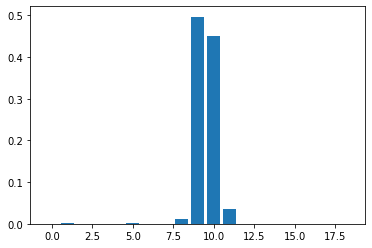

In [70]:
importance = rf.feature_importances_
for i,v in enumerate(importance):
    print('feature:%0d, score: %.5f' %(i,v))
    
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [71]:
X_train_dummy.columns[9:11]

Index(['Stop Resolution_Field Contact', 'Stop Resolution_Offense Report'], dtype='object')

In [72]:
features2 = ['Subject Perceived Race_Asian',
       'Subject Perceived Race_Black or African American',
       'Subject Perceived Race_Hispanic',
       'Subject Perceived Race_Multi-Racial',
       'Subject Perceived Race_Native Hawaiian or Other Pacific Islander',
       'Subject Perceived Race_Not Specified', 'Subject Perceived Race_Other',
       'Subject Perceived Race_White', 'Stop Resolution_Citation / Infraction',
       'Stop Resolution_Referred for Prosecution', 'Officer Race_Asian',
       'Officer Race_Black or African American',
       'Officer Race_Hispanic or Latino',
       'Officer Race_Nat Hawaiian/Oth Pac Islander',
       'Officer Race_Not Specified', 'Officer Race_Two or More Races',
       'Officer Race_White']

In [73]:
x2_dummy = dummy_df[features2]

In [74]:
X2_train_dummy, X2_test_dummy, y2_train_dummy, y2_test_dummy = train_test_split(x2_dummy,y, test_size = 0.3, random_state = 0)
logreg2 = LogisticRegression().fit(X2_train_dummy,y2_train_dummy)
y_pred2 = logreg2.predict(X2_test_dummy)
accuracy_score(y_pred2, y2_test_dummy)

0.7539263226460158

In [75]:
logged_odds = logreg2.intercept_
odds = np.exp(logged_odds)
probability = (odds/(1+odds))
print("Null model of probability of being arrested is" + " "+ str(268/(268+500)))
print("The odds of being arrested is" + " " + str(0.34895833/(1-0.34895833)))
print("the logged odds of being arrested is" + " " + str(np.log(odds)))

Null model of probability of being arrested is 0.3489583333333333
The odds of being arrested is 0.53599999213568
the logged odds of being arrested is [-1.12158569]


In [76]:
print(logreg2.coef_)
print(logreg2.intercept_)

[[ 0.00981063 -0.01116059 -0.27397343 -0.45622811 -0.06763642 -0.6297463
  -0.23997154 -0.25808681 -2.7003467  -3.80976509  0.14461702 -0.07473906
   0.14164673 -0.16341102  0.22929262  0.29735594  0.25414552]]
[-1.12158569]


In [77]:
both_dfdummy = pd.concat([df, dummy_df], axis=1)

In [78]:
features2 = ['White_Officer', 'Subject_POC', 'Officer_Age', 'under_17',
             'Morning', 'Afternoon', 'Evening', 'Night','Subject Perceived Race_Asian',
             'Subject Perceived Race_Black or African American',
             'Subject Perceived Race_Hispanic',
             'Subject Perceived Race_Multi-Racial',
             'Subject Perceived Race_Native Hawaiian or Other Pacific Islander',
             'Subject Perceived Race_Not Specified', 'Subject Perceived Race_Other',
             'Subject Perceived Race_White', 'Stop Resolution_Citation / Infraction',
             'Stop Resolution_Referred for Prosecution', 'Officer Race_Asian',
             'Officer Race_Black or African American',
             'Officer Race_Hispanic or Latino',
             'Officer Race_Nat Hawaiian/Oth Pac Islander',
             'Officer Race_Not Specified', 'Officer Race_Two or More Races',
             'Officer Race_White']
x_both = both_dfdummy[features2]

In [79]:
X_train_both, X_test_both, y_train_both, y_test_both = train_test_split(x_both,y, test_size = 0.3, random_state = 0)
logreg3 = LogisticRegression().fit(X_test_both,y_test_both)
y_pred3 = logreg3.predict(X_test_both)
accuracy_score(y_pred2, y2_test_dummy)

/Users/aratliff/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.7539263226460158

In [81]:
logged_odds2 = logreg3.intercept_
odds2 = np.exp(logged_odds2)
probability2 = (odds2/(1+odds2))
print("Null model of probability of being arrested is" + " "+ str(268/(268+500)))
print("The odds of being arrested is" + " " + str(0.34895833/(1-0.34895833)))
print("the logged odds of being arrested is" + " " + str(np.log(odds2)))

Null model of probability of being arrested is 0.3489583333333333
The odds of being arrested is 0.53599999213568
the logged odds of being arrested is [-0.10895837]


In [82]:
print(logreg3.coef_)
print(logreg3.intercept_)

[[ 6.42606442e-03  6.42606442e-03  9.06098084e-02  9.06098084e-02
  -1.20538840e-02 -1.20538840e-02 -7.69891735e-02 -7.69891735e-02
   2.60379246e-02  2.60379246e-02 -1.41741426e-02 -1.41741426e-02
   1.66854923e-03  1.66854923e-03 -1.90536402e-02 -1.90536402e-02
  -1.90683110e-01 -2.10428437e-01 -2.80502734e-01 -4.18401463e-01
   9.35522351e-02 -8.20037701e-01  2.50900611e-01 -1.84846100e-01
  -1.01915485e+00 -3.18777789e+00 -1.44278183e-01 -2.68045945e-01
   3.75937467e-02 -9.74282150e-02 -1.43630043e-01 -2.77758548e-02
   6.42606442e-03]]
[-0.10895837]


### Updated Model Logreg

In [83]:
both_dfdummy = pd.concat([df, dummy_df], axis=1)

In [85]:
features3 = ['White_Officer', 'Subject_POC', 'Officer_Age', 'under_17',
             'Morning', 'Afternoon', 'Evening', 'Night','Subject Perceived Race_Asian',
             'Subject Perceived Race_Black or African American',
             'Subject Perceived Race_Hispanic',
             'Subject Perceived Race_Multi-Racial',
             'Subject Perceived Race_Native Hawaiian or Other Pacific Islander',
             'Subject Perceived Race_Not Specified', 'Subject Perceived Race_Other',
             'Subject Perceived Race_White', 'Stop Resolution_Citation / Infraction',
             'Stop Resolution_Referred for Prosecution', 'Officer Race_Asian',
             'Officer Race_Black or African American',
             'Officer Race_Hispanic or Latino',
             'Officer Race_Nat Hawaiian/Oth Pac Islander',
             'Officer Race_Not Specified', 'Officer Race_Two or More Races',
             'Officer Race_White']
x_both = both_dfdummy[features3]

In [86]:
#Train test split
X_train_both, X_test_both, y_train_both, y_test_both = train_test_split(x_both,y, test_size = 0.3, random_state = 0)
logreg3 = LogisticRegression().fit(X_test_both,y_test_both)
y_pred3 = logreg3.predict(X_test_both)
accuracy_score(y_pred2, y2_test_dummy)

/Users/aratliff/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.7539263226460158

In [87]:
logged_odds2 = logreg3.intercept_
odds2 = np.exp(logged_odds2)
probability2 = (odds2/(1+odds2))
print("Null model of probability of being arrested is" + " "+ str(268/(268+500)))
print("The odds of being arrested is" + " " + str(0.34895833/(1-0.34895833)))
print("the logged odds of being arrested is" + " " + str(np.log(odds2)))

Null model of probability of being arrested is 0.3489583333333333
The odds of being arrested is 0.53599999213568
the logged odds of being arrested is [-0.10895837]


In [88]:
print(logreg3.coef_)
print(logreg3.intercept_)

[[ 6.42606442e-03  6.42606442e-03  9.06098084e-02  9.06098084e-02
  -1.20538840e-02 -1.20538840e-02 -7.69891735e-02 -7.69891735e-02
   2.60379246e-02  2.60379246e-02 -1.41741426e-02 -1.41741426e-02
   1.66854923e-03  1.66854923e-03 -1.90536402e-02 -1.90536402e-02
  -1.90683110e-01 -2.10428437e-01 -2.80502734e-01 -4.18401463e-01
   9.35522351e-02 -8.20037701e-01  2.50900611e-01 -1.84846100e-01
  -1.01915485e+00 -3.18777789e+00 -1.44278183e-01 -2.68045945e-01
   3.75937467e-02 -9.74282150e-02 -1.43630043e-01 -2.77758548e-02
   6.42606442e-03]]
[-0.10895837]


In [89]:
print(confusion_matrix(y_test_both, y_pred3))
print(classification_report(y_test_both, y_pred3))

[[10417     0]
 [ 3400     0]]
              precision    recall  f1-score   support

           0       0.75      1.00      0.86     10417
           1       0.00      0.00      0.00      3400

    accuracy                           0.75     13817
   macro avg       0.38      0.50      0.43     13817
weighted avg       0.57      0.75      0.65     13817



/Users/aratliff/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/aratliff/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/aratliff/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



## Decision Tree

In [35]:
X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(x_both, y, test_size=0.30, random_state=0)

In [36]:
#Model
classifier = DecisionTreeClassifier()
classifier.fit(X_train_dt, y_train_dt)a

DecisionTreeClassifier()

In [37]:
y_pred_dt = classifier.predict(X_test_dt)

In [38]:
#Evaluation 
print(confusion_matrix(y_test_dt, y_pred_dt))
print(classification_report(y_test_dt, y_pred_dt))

[[10048   369]
 [ 3203   197]]
              precision    recall  f1-score   support

           0       0.76      0.96      0.85     10417
           1       0.35      0.06      0.10      3400

    accuracy                           0.74     13817
   macro avg       0.55      0.51      0.47     13817
weighted avg       0.66      0.74      0.66     13817



## KNN 

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)

In [91]:
#Model
knn = KNeighborsClassifier(n_neighbors=5, p=2)

In [92]:
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [93]:
y_pred= knn.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [94]:
#Evaluation
cm = confusion_matrix(y_test, y_pred)
print (cm)

[[6300  638]
 [2001  272]]


In [95]:
print('Original F1 Score:', (f1_score(y_test, y_pred)))
print('Original Accuracy Score:', (accuracy_score(y_test, y_pred)))

Original F1 Score: 0.17090794847628024
Original Accuracy Score: 0.7134947345565085


In [ ]:
#

In [17]:
yes_arrested = training[training.Arrested==1] 
not_arrested = training[training.Arrested==0]

In [33]:
arrested_upsampled = resample(yes_arrested,
                        replace=True,
                        n_samples=len(not_arrested),
                        random_state=23)

In [34]:
arrested_upsampled.shape

(27774, 9)

In [35]:
upsampled = pd.concat([not_arrested, arrested_upsampled])

upsampled.Arrested.value_counts()

1    27774
0    27774
Name: Arrested, dtype: int64

In [47]:
y_train_up = upsampled.Arrested
X_train_up = upsampled.drop('Arrested', axis=1)

upsampled_knn = KNeighborsClassifier(n_neighbors=5, p=2)
upsampled_knn.fit(X_train_up, y_train_up)
upsampled_pred = upsampled_knn.predict(X_test)

print('Upsampled F1 Score:', f1_score(y_test, upsampled_pred))
print('Upsampled Accuracy score: ', accuracy_score(y_test, upsampled_pred))

Upsampled F1 Score: 0.3114607545145718
Upsampled Accuracy score:  0.5819129301921615
